# The notebook contains
### Code for _Bulyan_ aggregation algorithm, *when gradient updates of benign clients are unknown to adversary*
### Evaluation of all of the attacks (Fang, LIE, and our SOTA AGR-tailored and AGR-agnstic) on Bulyan

## Import packages

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from __future__ import print_function
import argparse, os, sys, csv, shutil, time, random, operator, pickle, ast, math
import numpy as np
import pandas as pd
from torch.optim import Optimizer
import torch.nn.functional as F
import torch
import pickle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torch.multiprocessing as mp
import math
sys.path.insert(0,'./../utils/')
from logger import *
from eval import *
from misc import *

from cifar10_normal_train import *
from cifar10_util import *
from adam import Adam
from sgd import SGD


## Load Data
Divide cifar10 data among 50 clients in Non-IID fashion using Dirichlet distribution

In [3]:
nusers = 50
user_tr_len = pickle.load(open('./data/user_tr_len.pkl','rb'))

user_train_data_tensors = pickle.load(open('./data/user_train_data_tensors.pkl','rb'))
user_train_label_tensors = pickle.load(open('./data/user_train_label_tensors.pkl','rb'))

val_data_tensor = pickle.load(open('./data/val_data_tensor.pkl','rb'))
val_label_tensor = pickle.load(open('./data/val_label_tensor.pkl','rb'))
te_data_tensor = pickle.load(open('./data/te_data_tensor.pkl','rb'))
te_label_tensor = pickle.load(open('./data/te_label_tensor.pkl','rb'))

## Our Aggregation Function

In [4]:
def our_mean_defense(all_updates, n_attackers, history_updates):
    discarded_history = get_discarded_index(n_attackers, history_updates)

    mask = torch.ones(all_updates.size(0), dtype=torch.bool)
    mask[discarded_history] = False
    remaining_updates = all_updates[mask]

    print('discarded index', discarded_history)

    return torch.nanmean(remaining_updates, dim=0)

####
def euclidean_distance(row1, row2):
    return torch.sqrt(torch.sum((row1 - row2) ** 2))
####

def get_discarded_index(n_attackers, history_updates):
    n_users = history_updates.shape[0]

    ####
    distance_matrix = [[0 if i == j else euclidean_distance(history_updates[i, :], history_updates[j, :]) for j in range(n_users)] for i in range(n_users)]
    ####

    sum_of_distances = [sum(row) for row in distance_matrix]

    discarded_history = []
    for _ in range(n_attackers):
        max_distance = max(sum_of_distances)
        index_of_max_distance = sum_of_distances.index(max_distance)
        discarded_history.append(index_of_max_distance)

        for i in range(n_users):
            sum_of_distances[i] -= distance_matrix[i][index_of_max_distance]
        sum_of_distances[index_of_max_distance] = -1

    return discarded_history


## Code for Multi-krum aggregation algorithm

In [5]:
def multi_krum(all_updates, n_attackers, multi_k=False):

    candidates = []
    candidate_indices = []
    remaining_updates = all_updates
    all_indices = np.arange(len(all_updates))

    while len(remaining_updates) > 2 * n_attackers + 2:
        torch.cuda.empty_cache()
        distances = []
        for update in remaining_updates:
            distance = []
            for update_ in remaining_updates:
                distance.append(torch.norm((update - update_)) ** 2)
            distance = torch.Tensor(distance).float()
            distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)

        distances = torch.sort(distances, dim=1)[0]
        scores = torch.sum(distances[:, :len(remaining_updates) - 2 - n_attackers], dim=1)
        indices = torch.argsort(scores)[:len(remaining_updates) - 2 - n_attackers]

        candidate_indices.append(all_indices[indices[0].cpu().numpy()])
        all_indices = np.delete(all_indices, indices[0].cpu().numpy())
        candidates = remaining_updates[indices[0]][None, :] if not len(candidates) else torch.cat((candidates, remaining_updates[indices[0]][None, :]), 0)
        remaining_updates = torch.cat((remaining_updates[:indices[0]], remaining_updates[indices[0] + 1:]), 0)
        if not multi_k:
            break
    # print(len(remaining_updates))

    aggregate = torch.mean(candidates, dim=0)

    return aggregate, np.array(candidate_indices)

## Code for Bulyan aggregation algorithm

In [6]:
def bulyan(all_updates, n_attackers):
    nusers = all_updates.shape[0]
    bulyan_cluster = []
    candidate_indices = []
    remaining_updates = all_updates
    all_indices = np.arange(len(all_updates))

    while len(bulyan_cluster) < (nusers - 2 * n_attackers):
        torch.cuda.empty_cache()
        distances = []
        for update in remaining_updates:
            distance = []
            for update_ in remaining_updates:
                distance.append(torch.norm((update - update_)) ** 2)
            distance = torch.Tensor(distance).float()
            distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)
        # print(distances)

        distances = torch.sort(distances, dim=1)[0]

        scores = torch.sum(distances[:, :len(remaining_updates) - 2 - n_attackers], dim=1)
        indices = torch.argsort(scores)[:len(remaining_updates) - 2 - n_attackers]
        if not len(indices):
            break
        candidate_indices.append(all_indices[indices[0].cpu().numpy()])
        all_indices = np.delete(all_indices, indices[0].cpu().numpy())
        bulyan_cluster = remaining_updates[indices[0]][None, :] if not len(bulyan_cluster) else torch.cat((bulyan_cluster, remaining_updates[indices[0]][None, :]), 0)
        remaining_updates = torch.cat((remaining_updates[:indices[0]], remaining_updates[indices[0] + 1:]), 0)

    # print('dim of bulyan cluster ', bulyan_cluster.shape)

    n, d = bulyan_cluster.shape
    param_med = torch.median(bulyan_cluster, dim=0)[0]
    sort_idx = torch.argsort(torch.abs(bulyan_cluster - param_med), dim=0)
    sorted_params = bulyan_cluster[sort_idx, torch.arange(d)[None, :]]

    return torch.mean(sorted_params[:n - 2 * n_attackers], dim=0), np.array(candidate_indices)

## our_attack_mean
$ argmin_\theta(\ -L(\theta_{attacker(s)}) + \lambda_1 |\bar{\theta_{abs\ mean\ benige\ users}} - \bar{\theta_{abs\ attacker(s)}}|$

In [7]:
device = 'cuda:0'
def check_condition(lambda1, prev_grad, loss_grad, history, all_updates, n_users, n_attacker, epoch_num):
    loss_grad = loss_grad.to(device)
    prev_grad = prev_grad.to(device)
    new_grad = lambda1 * (loss_grad + prev_grad)

    ####
    mal_updates = torch.stack([new_grad.clone().detach() for _ in range(n_attacker)])
    malicious_grads = torch.cat((mal_updates, all_updates[n_attacker:]), 0)

    history_updates = history.clone().detach()
    history_updates[:, epoch_num] = malicious_grads.abs().mean(dim=1, keepdim=True).squeeze()
    ####

    discarded_history = get_discarded_index(n_attacker+2, history_updates)

    detected_mal = len([item for item in discarded_history if item < 10])
    return detected_mal / len(discarded_history) <= n_attacker / n_users

def find_upper_bound(lambda1, prev_grad, loss_grad, history, all_updates, n_users, n_attacker, epoch_num):
    while check_condition(lambda1, prev_grad, loss_grad, history, all_updates, n_users, n_attacker, epoch_num):
        lambda1 *= 2  # Exponentially increase lambda
    return lambda1


def projection(prev_grad, loss_grad, history, all_updates, n_users, n_attacker, epoch_num):
    updates_abs_mean = all_updates.abs().mean(dim=1, keepdim=True)
    median_value = torch.median(updates_abs_mean).item()

    ####
    history_updates = history.clone().detach()
    history_updates[:, epoch_num] = updates_abs_mean.mean(dim=1, keepdim=True).squeeze()
    ####

    loss_grad = loss_grad.to(device)
    prev_grad = prev_grad.to(device)

    lambda_low = median_value/(prev_grad + loss_grad).abs().mean().item()
    lambda_high = find_upper_bound(lambda_low, prev_grad, loss_grad, history_updates, all_updates, n_users, n_attacker, epoch_num)
    if lambda_high < lambda_low:
        lambda_high = lambda_low
        print("SHOULD NEVER REACH THIS LINE")
        print('lambda_low: ', lambda_low, ' lambda_high: ', lambda_high)
    tolerance = 1e-6

    iterations_count = 0
    while lambda_high - lambda_low > tolerance and iterations_count < 1:
        lambda_mid = (lambda_low + lambda_high) / 2
        if check_condition(lambda_mid, prev_grad, loss_grad, history_updates, all_updates, n_users, n_attacker, epoch_num):
            lambda_low = lambda_mid
        else:
            lambda_high = lambda_mid
        iterations_count += 1

    lambda1 = lambda_low

    return lambda1 * (prev_grad + loss_grad)

def our_attack_mean(n_user, epoch_num, history_updates, all_updates, model_params, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors):
    attacker_tr_data_tensor = user_train_data_tensors[0].cuda()
    attacker_tr_label_tensor = user_train_label_tensors[0].cuda()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    fed_model.eval()  # Ensure the model is in evaluation mode

    new_grad = -all_updates[0].clone().detach().requires_grad_(True)
    prev_grad = np.zeros(len(new_grad))
    new_grad = projection(torch.from_numpy(prev_grad), new_grad, history_updates, all_updates, n_user, n_attacker, epoch_num)

    for _ in range(10):
        outputs = fed_model(attacker_tr_data_tensor)
        loss = criterion(outputs, attacker_tr_label_tensor)

        loss.backward(retain_graph=True)
        param_grad = []
        for param in fed_model.parameters():
            param_grad.append(param.grad.view(-1).detach())

        param_grad = torch.cat(param_grad)
        prev_grad = new_grad
        new_grad = projection(prev_grad, param_grad, history_updates, all_updates, n_user, n_attacker, epoch_num)

        difference = torch.mean(torch.abs(new_grad - prev_grad)).item()
        if difference < 1e-6:
            # print("STOPPED! Difference is too small, stop finding best attack grad")
            break

        fed_model.zero_grad()

    result_attacker_grads = [new_grad.clone().detach() for _ in range(10)]
    return torch.stack(result_attacker_grads).cuda()


## our attack (10 attacker) + bulyan

In [8]:
nepochs = 5

In [9]:
batch_size=250
resume=0

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []

title = "our attack (10 attacker) + bulyan"

for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    ####
    history = torch.zeros((nusers, nepochs + 1), dtype=torch.float32).cuda()
    ####

    model_grads = []
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(nusers): # 50
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            targets = targets.type(torch.LongTensor)

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))


            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        if n_attacker > 0:
            model_params = torch.cat([p.data.view(-1) for p in fed_model.parameters()])
            mal_updates = our_attack_mean(nusers, epoch_num, history, user_grads, model_params, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)

        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)

        history[:, epoch_num] = updates_abs_mean.squeeze()

        agg_grads, krum_candidate=bulyan(malicious_grads, 0)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc


        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num,
            'loss': val_loss,
            'validation accuracy': val_acc,
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv(f'{title}.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break

        epoch_num+=1

c:\Users\Hizan\Desktop\CPEN497-FL\attack-defense\sgd.py:109: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1630.)
  p.data.add_(-group['lr'], d_p)
C:\Users\Hizan\AppData\Local\Temp\ipykernel_7508\3035937951.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


epoch: 0, bulyan: at our-agr n_at 10 e 0 | val loss 2.3021 val acc 10.3084 best val_acc 10.308442
epoch: 1, bulyan: at our-agr n_at 10 e 1 | val loss 2.3018 val acc 10.3084 best val_acc 10.308442
epoch: 2, bulyan: at our-agr n_at 10 e 2 | val loss 2.3016 val acc 10.3084 best val_acc 10.308442
epoch: 3, bulyan: at our-agr n_at 10 e 3 | val loss 2.3015 val acc 11.0998 best val_acc 11.099838
epoch: 4, bulyan: at our-agr n_at 10 e 4 | val loss 2.3015 val acc 9.8620 best val_acc 11.099838
epoch: 5, bulyan: at our-agr n_at 10 e 5 | val loss 2.3014 val acc 9.8620 best val_acc 11.099838


## Code for fang attack on Bulyan
### Note that Fang attacks on Multi-krum and Bulyan are the same

In [10]:
def compute_lambda_fang(all_updates, model_re, n_attackers):

    distances = []
    n_benign, d = all_updates.shape
    for update in all_updates:
        distance = torch.norm((all_updates - update), dim=1)
        distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)

    distances[distances == 0] = 10000
    distances = torch.sort(distances, dim=1)[0]
    scores = torch.sum(distances[:, :n_benign - 2 - n_attackers], dim=1)
    min_score = torch.min(scores)
    term_1 = min_score / ((n_benign - n_attackers - 1) * torch.sqrt(torch.Tensor([d]))[0])
    max_wre_dist = torch.max(torch.norm((all_updates - model_re), dim=1)) / (torch.sqrt(torch.Tensor([d]))[0])
    # print(term_1 + max_wre_dist) # tensor(0.0001, device='cuda:0')
    return (term_1 + max_wre_dist)


def get_malicious_updates_fang(all_updates, model_re, deviation, n_attackers):
 
    lamda = compute_lambda_fang(all_updates, model_re, n_attackers) # tensor(0.0001, device='cuda:0')
    
    threshold = 1e-5

    mal_updates = []
    while lamda > threshold:
        # print("lamda: ", lamda)
        mal_update = (- lamda * deviation) # torch.Size([2472266])
        mal_updates = torch.stack([mal_update] * n_attackers)   # torch.Size([2, 2472266])
        mal_updates = torch.cat((mal_updates, all_updates), 0)  # torch.Size([12, 2472266])

        agg_grads, krum_candidate = multi_krum(mal_updates, n_attackers, multi_k=False) # agg_grads.shape torch.Size([2472266]) # krum_candidate.shape torch.Size(1,)
        print("krum_candidate: ", krum_candidate)
        if krum_candidate < n_attackers:
            return mal_update
        
        lamda *= 0.5

    if not len(mal_updates):
        # print(lamda, threshold)
        mal_update = (model_re - lamda * deviation)
    return mal_update  # len(mal_update) 2472266

## Execute Fang attack on Bulyan

In [11]:
batch_size=250
resume=0

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='fang'
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

title = "Fang attack on Bulyan"

for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0
    
    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])
    while epoch_num <= nepochs:
        user_grads=[]

        # for i in range(n_attacker, nusers):
        for i in range(nusers):
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = targets.type(torch.LongTensor)   
            
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        if n_attacker > 0:
            agg_grads = torch.mean(user_grads, 0)
            deviation = torch.sign(agg_grads)
            mal_update = get_malicious_updates_fang(user_grads, agg_grads, deviation, n_attacker)
            malicious_grads = torch.cat((torch.stack([mal_update] * n_attacker), user_grads[n_attacker:]), 0)

        
        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
            sys.exit()
            
        if  torch.isnan(updates_abs_mean).any():
            print("updates_abs_mean contains a nan value")
            nan_indices = torch.where(torch.isnan(updates_abs_mean))
            print("updates_abs_mean has nan value at these index: ", nan_indices)
            user_grad_nan_index = torch.where(user_grads[nan_indices[0]])
            print("user_grads has nan value at these index", user_grad_nan_index)
            print(user_grads[nan_indices[0]][user_grad_nan_index])

        agg_grads, krum_candidate=bulyan(malicious_grads, 0)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        
        print('epoch: %d, %s: at %s n_at %d n_mal_sel %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, np.sum(krum_candidate < n_attacker), epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv(f'{title}.csv', index=False)
        epoch_num+=1

krum_candidate:  [50]
krum_candidate:  [50]
krum_candidate:  [50]
krum_candidate:  [0]
epoch: 0, bulyan: at fang n_at 10 n_mal_sel 10 e 0 | val loss 2.3036 val acc 9.7200 best val_acc 9.719968


C:\Users\Hizan\AppData\Local\Temp\ipykernel_7508\1855536710.py:120: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


krum_candidate:  [50]
krum_candidate:  [38]
krum_candidate:  [38]
krum_candidate:  [0]
epoch: 1, bulyan: at fang n_at 10 n_mal_sel 10 e 1 | val loss 2.3034 val acc 9.7808 best val_acc 9.780844
krum_candidate:  [50]
krum_candidate:  [50]
krum_candidate:  [0]
epoch: 2, bulyan: at fang n_at 10 n_mal_sel 10 e 2 | val loss 2.3034 val acc 10.2273 best val_acc 10.227273
krum_candidate:  [38]
krum_candidate:  [38]
krum_candidate:  [38]
krum_candidate:  [0]
epoch: 3, bulyan: at fang n_at 10 n_mal_sel 10 e 3 | val loss 2.3033 val acc 12.6826 best val_acc 12.682630
krum_candidate:  [24]
krum_candidate:  [50]
krum_candidate:  [24]
krum_candidate:  [0]
epoch: 4, bulyan: at fang n_at 10 n_mal_sel 10 e 4 | val loss 2.3032 val acc 9.6997 best val_acc 12.682630
krum_candidate:  [38]
krum_candidate:  [38]
krum_candidate:  [38]
krum_candidate:  [0]
epoch: 5, bulyan: at fang n_at 10 n_mal_sel 10 e 5 | val loss 2.3031 val acc 9.6997 best val_acc 12.682630


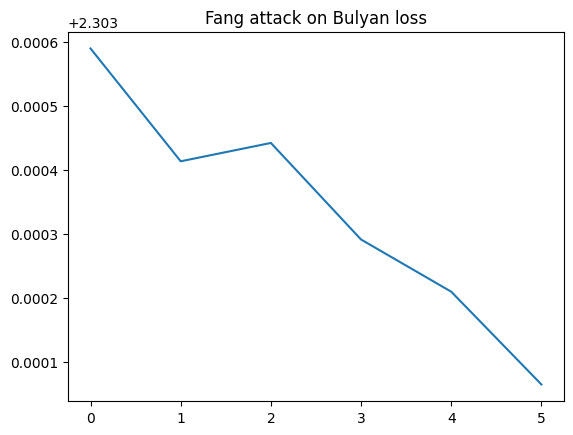

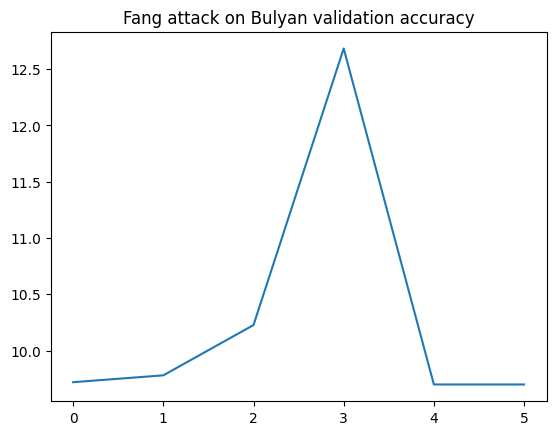

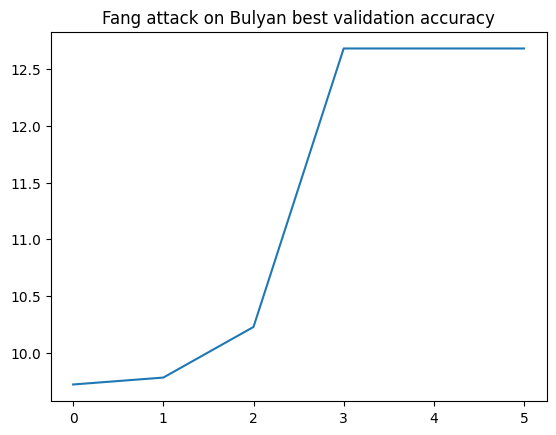

In [12]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title(f"{title} {col}")
    plt.show()

## Code for LIE attack + bulyan

In [13]:
def lie_attack(all_updates, z):
    avg = torch.mean(all_updates, dim=0)
    std = torch.std(all_updates, dim=0)
    return avg + z * std

In [14]:
batch_size=250
resume=0
schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='lie'
z_values={3:0.69847, 5:0.7054, 8:0.71904, 10:0.72575, 12:0.73891}
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

title = "LIE attack + bulyan"

for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_attacker, nusers):
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        if n_attacker > 0:
            mal_update = lie_attack(user_grads, z_values[n_attacker])
            malicious_grads = torch.cat((torch.stack([mal_update]*n_attacker), user_grads[n_attacker:]))
                        
        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
            sys.exit()
            
        agg_grads, krum_candidate=bulyan(malicious_grads, n_attacker)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num,
            'loss': val_loss,
            'validation accuracy': val_acc,
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv(f'{title}.csv', index=False)

        if val_loss > 10:
            print('val loss %f too high'%val_loss)
            break

        epoch_num+=1

torch.Size([60, 2472266])


SystemExit: 

c:\Users\Hizan\.conda\envs\cpen333\lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


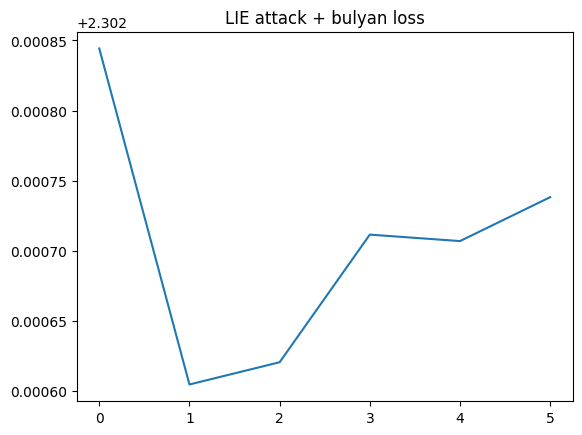

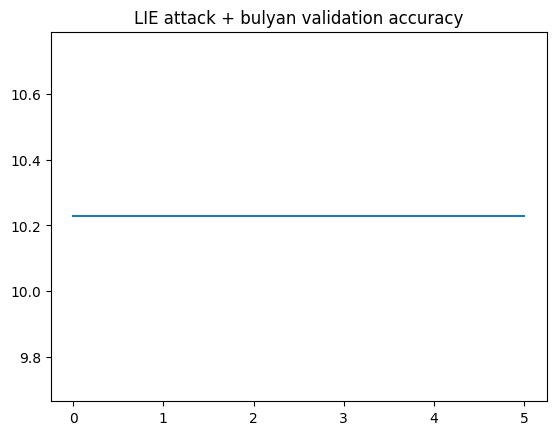

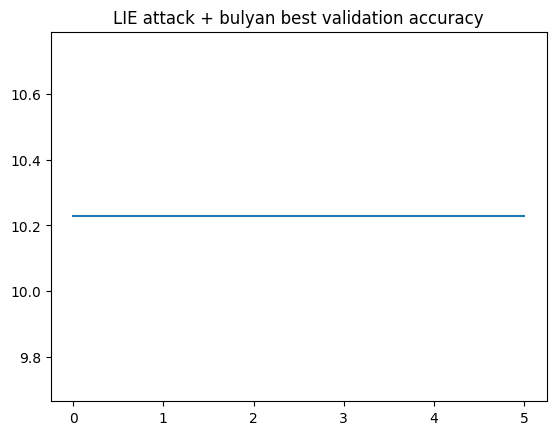

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title(f"{title} {col}")
    plt.show()